# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Deploy, monitor and maintain your system

## 1. Frame the problem
todo


In [18]:
# Imports
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
# Settings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)


## 2. Get the data

In [20]:
df = pd.read_csv('data/german.data', delimiter=' ', header=None)
df.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2
999,A12,45,A34,A41,4576,A62,A71,3,A93,A101,...,A123,27,A143,A152,1,A173,1,A191,A201,1


In [21]:
# View the attribute names from the info document
path = 'data/german.doc'

with open(path, mode='r') as file:
    text = file.read()
    
pattern = r"Attr?ibute (?P<attr>\d{1,2}):.+?\n\s+(?P<name>.+?)\n"

print("Feature number and name:")
for m in re.finditer(pattern, text):
    print("{attr}: {name}".format(**m.groupdict()))

Feature number and name:
1: Status of existing checking account
2: Duration in month
3: Credit history
4: Purpose
5: Credit amount
6: Savings account/bonds
7: Present employment since
8: Installment rate in percentage of disposable income
9: Personal status and sex
10: Other debtors / guarantors
11: Present residence since
12: Property
13: Age in years
14: Other installment plans 
15: Housing
16: Number of existing credits at this bank
17: Job
18: Number of people being liable to provide maintenance for
19: Telephone
20: foreign worker


In [22]:
# Define short user freindly column names for easy EDA
col_names = [
    "status",    #1 (balance)
    "duration",  #2 (tenure)
    "history",   #3
    "purpose",   #4 (purpose of the loan)
    "amount",    #5 (credit amount requested)
    "savings",   #6 (savings or bonds)
    "employment",#7 (curent employment duration)
    "income",     #8 (Installment rate in percentage of disposable income)
    "personal",  #9 (Personal status and sex)
    "guarantor", #10
    "residence", #11
    "property",  #12
    "age",       #13
    "installments", #14 (Other installment plans)
    "housing",    #15
    "credits",      #16 (Number of existing credits at this bank)
    "job",        #17
    "maintenance", #18
    "telephone",  #19
    "foreign",    #20
    "label"
            ]
df.columns = col_names

df.head()

,status,duration,history,purpose,amount,savings,employment,income,personal,guarantor,...,property,age,installments,housing,credits,job,maintenance,telephone,foreign,label
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Rename the categories

In [23]:
# Make a mapping for categories
mapping = {
0: {
    'A11' : "overdrawn",
    'A12' : "up to 200 DM",
    'A13' : "monthly salary",
    'A14' : "no account"
    },

2: {
    'A30' : "no loans",
    'A31' : "duly paid",
    'A32' : "so far so good",
    'A33' : "delay",
    'A34' : "critical",
},

3: {
    'A40' : "car",
    'A41' : "used car",
    'A42' : "furniture",
    'A43' : "television",
    'A44' : "appliances",
    'A45' : "repairs",
    'A46' : "education",
    'A47' : "vacation",
    'A48' : "retraining",
    'A49' : "business",
    'A410': "other",
},

5: {
    'A61' : "[0, 1000) DM",
    'A62' : "[100, 500) DM",
    'A63' : "[500, 1000) DM",
    'A64' : "[1000, ∞) DM",
    'A65' : "no savings",
}, 

6: {
    'A71' : "unemployed",
    'A72' : "[0, 1)",
    'A73' : "[1, 4)",
    'A74' : "[4, 7)",
    'A75' : "[7, ∞)",
},

8: {
    'A91' : "male divorced/separated",
    'A92' : "female divorced/separated/married",
    'A93' : "male single",
    'A94' : "male married/widowed",
    'A95' : "female single",
},

9: {
    'A101' : "none",
    'A102' : "co-applicant",
    'A103' : "guarantor",
},

11: {
    'A121' : "real estate",
    'A122' : "building",
    'A123' : "car",
    'A124' : "unknown",
},

13: {
    'A141' : "bank",
    'A142' : "stores",
    'A143' : "none",
},

14: {
    'A151' : "rent",
    'A152' : "own",
    'A153' : "for free",
},

16: {
    'A171' : "unemployed/unskilled non-resident",
    'A172' : "unskilled",
    'A173' : "skilled",
    'A174' : "white color",
},

18: {
    'A191' : "none",
    'A192' : "yes",
},

19: {
    'A201' : True,
    'A202' : False,
},

20: {
    1: 0,  # good
    2: 1,  # bad
}}


In [24]:
# Rename the categories
for i, d in mapping.items():
    df.iloc[:, i] = df.iloc[:, i].map(d)

In [25]:
# Rearrange the columns: num, cat, label
df = pd.concat([df.select_dtypes(np.number), df.select_dtypes(object)], axis=1)
df['label'] = df.pop('label')
df.head()

,duration,amount,income,residence,age,credits,maintenance,status,history,purpose,...,employment,personal,guarantor,property,installments,housing,job,telephone,foreign,label
0,6,1169,4,4,67,2,1,overdrawn,critical,television,...,"[7, ∞)",male single,none,real estate,none,own,skilled,yes,True,0
1,48,5951,2,2,22,1,1,up to 200 DM,so far so good,television,...,"[1, 4)",female divorced/separated/married,none,real estate,none,own,skilled,none,True,1
2,12,2096,2,3,49,1,2,no account,critical,education,...,"[4, 7)",male single,none,real estate,none,own,unskilled,none,True,0
3,42,7882,2,4,45,1,2,overdrawn,so far so good,furniture,...,"[4, 7)",male single,guarantor,building,none,for free,skilled,none,True,0
4,24,4870,3,4,53,2,2,overdrawn,delay,car,...,"[1, 4)",male single,none,unknown,none,for free,skilled,none,True,1


## Exploratory Data Analysis

In [9]:
print(f'proportion of "bad" customers: {df.label.sum() / len(df)}')

proportion of "bad" customers: 0.3


The following histograms show us that no feature can separate the two classes:

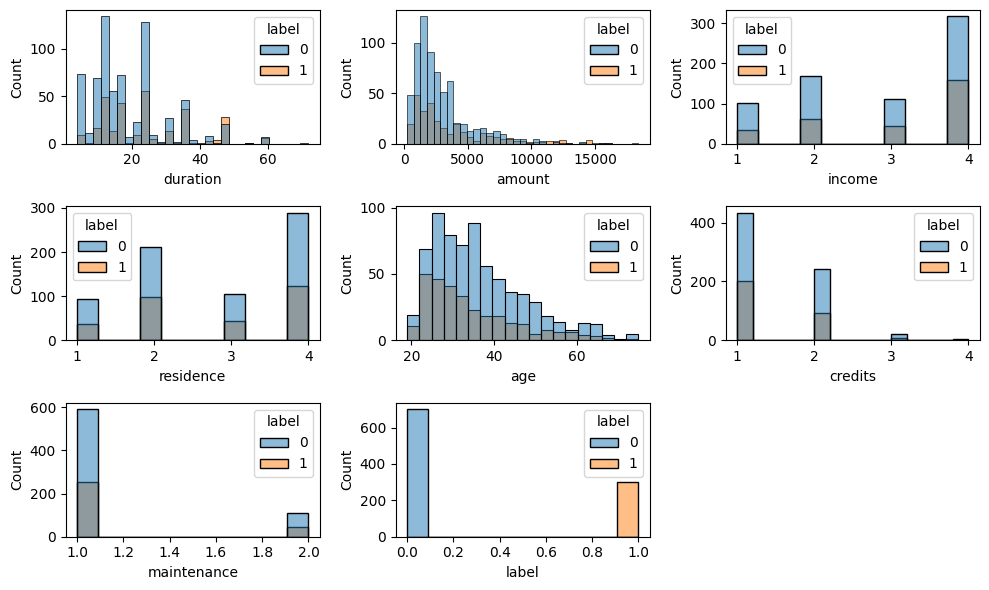

In [33]:
# Histograms of numerical features
df_num = df.select_dtypes(np.number).assign(label=df['label'])
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    if i >= df_num.shape[1]:
        plt.delaxes(ax)
        break
    sns.histplot(df_num, x=df_num.columns[i], hue='label', ax=ax)
plt.tight_layout()

The bottom row in the following scatter matrix shows us that there is no single feature that could be used to fit logistic regression on it in order to separate the two classes

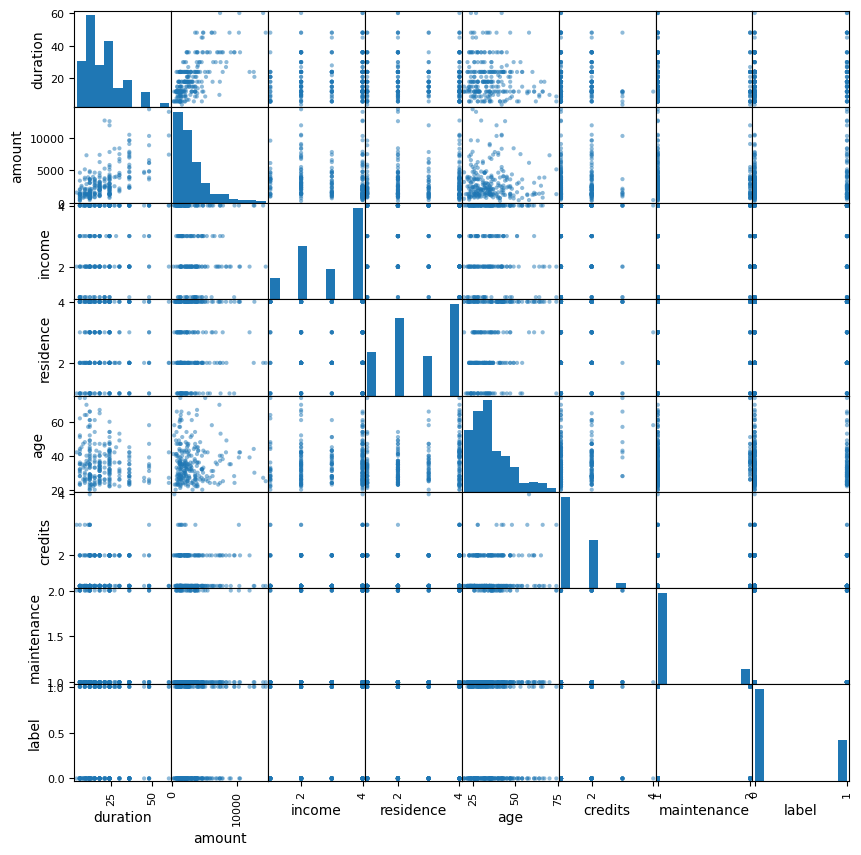

In [37]:
# Scattermatrix
from pandas.plotting import scatter_matrix
scatter_matrix(df_num.sample(250), figsize=(10,10));